In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [2]:
up = np.complex(0,1)
down = np.complex(0,-1)
left = np.complex(-1,0)
right = np.complex(1,0)

turnl = np.complex(0,1)
turnr = np.complex(0,-1)
reverse = np.complex(-1,0)

white = 0
blue = 1
red = 2
black = 3

quadcmap = ListedColormap(['w','b','r','k'])

In [3]:
RL = {white:(turnr,black), black:(turnl,white)}
LR = {white:(turnl,black), black:(turnr,white)}
RRLL = {white:(turnr,blue), blue:(turnr,red),
        red:(turnl,black), black:(turnl,white)}
RLLL = {white:(turnr,blue), blue:(turnl,red),
        red:(turnl,black), black:(turnl,white)}
RLRL = {white:(turnr,blue), blue:(turnl,red),
        red:(turnr,black), black:(turnl,white)}

In [4]:
# Default settings for an open (i.e. expandable) world
# For which we need a set (instead of an array)
bset = set()

# Then a function would be necessary to transform it into an array when plotting it
def into_array(bset):
    getrange = lambda l: (min(min(l,default=0),-3), max(max(l,default=0),3))
    xrange = getrange([pos[0] for pos in bset])
    yrange = getrange([pos[1] for pos in bset])
    grid = np.zeros([yrange[1]-yrange[0]+1,xrange[1]-xrange[0]+1], int)
    new_pos = [(yrange[1]-pos[1],pos[0]-xrange[0]) for pos in bset]
    grid[[pos[0] for pos in new_pos], [pos[1] for pos in new_pos]]=1
    return(grid)

# The following functions could be implemented in a different way if the colors are stored in an array
def check_clr(pos):
    if pos in bset:
        return(black)
    else:
        return(white)
    
def recolor(pos, color):
    if color == black:
        bset.add(pos)
    if color == white:
        bset.discard(pos)
        
defaultopen = (check_clr, recolor)

In [5]:
class ant:
    
    def __init__(self, pos, dir2d, check_clr=check_clr, rule=RL):
        self.pos = np.complex(*pos)
        self.dir = dir2d
        self.rule = rule
        self.check_clr = check_clr
        
    def loc(self):
        return((int(self.pos.real),int(self.pos.imag)))
    
    def color(self):
        return(self.check_clr(self.loc()))
    
    def turn_and_forward(self, toturn):
        self.dir = self.dir*toturn
        self.pos = self.pos+self.dir
        
    def step(self):
        toturn, tocolor = self.rule[self.color()]
        loc = self.loc()
        self.turn_and_forward(toturn)
        return((loc, tocolor))
        
    def wrapped(self, xrange, yrange):
        self.pos = np.complex(self.pos.real%xrange, self.pos.imag%yrange)
        
    def fixed(self, xrange, yrange):
        x,y = self.pos.real,self.pos.imag
        x -= (x<0)*x + (x>xrange-1)*(x-xrange+1)
        y -= (y<0)*y + (y>yrange-1)*(y-yrange+1)
        self.pos = np.complex(x,y)

In [6]:
class OpenWorld:
    
    def __init__(self, setting=defaultopen):
        self.antlist = []
        self.check_clr, self.recolor = setting
    
    def add_ant(self, pos, dir2d, rule=RL):
        self.antlist.append(ant(pos, dir2d, self.check_clr, rule))
        
    def step(self):
        changes = [a.step() for a in self.antlist]
        [self.recolor(*change) for change in changes]
        
    def steps(self, times=1):
        [self.step() for _ in range(times)]

In [7]:
class ClosedWorld:
    
    def __init__(self, xrange, yrange, boundary):
        self.ranges = (xrange, yrange)
        self.grid = np.zeros((yrange, xrange))
        self.boundary = boundary
        self.check_clr = lambda pos:self.grid[pos]
        self.antlist = []
    
    def add_ant(self, pos, dir2d, rule=RL):
        self.antlist.append(ant(pos, turnl*dir2d, self.check_clr, rule))
        
    def recolor(self, pos, color):
        self.grid[pos]=color
        
    def step(self):
        changes = [a.step() for a in self.antlist]
        [self.recolor(*change) for change in changes]
        if self.boundary == 'wrapped':
            [a.wrapped(*self.ranges) for a in self.antlist]
        if self.boundary == 'fixed':
            [a.fixed(*self.ranges) for a in self.antlist]
            
    def steps(self, times=1):
        [self.step() for _ in range(times)]
    
    def plot(self, ax, cmap):
        ax.imshow(self.grid,cmap=cmap,animated=True)

In [8]:
def ani_gen_open(world, path, title="", cmap='binary', duration=3e2):
    bset.clear()
    fig, ax = plt.subplots(1, figsize=(4, 4), facecolor=(1,1,1))
    def make_frame(t):
        ax.clear()
        ax.axis('off')
        ax.set_title(title, fontsize=16)
        world.step()
        ax.imshow(into_array(bset),cmap=cmap,animated=True)
        return(mplfig_to_npimage(fig))
    ani = VideoClip(make_frame, duration = duration)
    ani.write_videofile(path, fps=50)
    return

def ani_gen_closed(world, path, title="", cmap='binary', duration=3e2):
    bset.clear()
    fig, ax = plt.subplots(1, figsize=(4, 4), facecolor=(1,1,1))
    def make_frame(t):
        ax.clear()
        ax.axis('off')
        ax.set_title(title, fontsize=16)
        world.step()
        world.plot(ax,cmap)
        return(mplfig_to_npimage(fig))
    ani = VideoClip(make_frame, duration = duration)
    ani.write_videofile(path, fps=50)
    return

In [ ]:
import langton

<IPython.core.display.Javascript object>


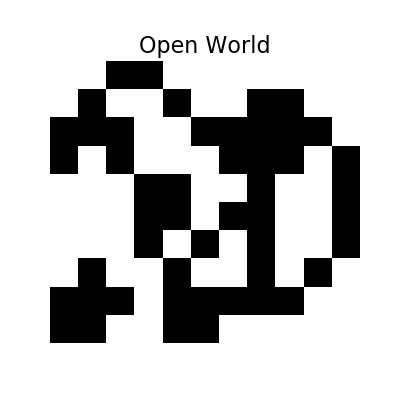

[MoviePy] >>>> Building video open1.mp4
[MoviePy] Writing video open1.mp4


100%|█████████▉| 250/251 [00:11<00:00, 20.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: open1.mp4 



In [9]:
%matplotlib notebook

world0 = OpenWorld()
world0.add_ant((0,0), right)
ani_gen_open(world0, 'open1.mp4', 'Open World', duration = 5)

In [ ]:
world1 = ClosedWorld(101,101,'wrapped')
world1.add_ant((50,50), right)
ani_gen_closed(world1, 'wrapped.mp4', 'Wrapped World', duration = 6e2)

In [ ]:
world2 = ClosedWorld(101,101,'fixed')
world2.add_ant((50,50), right)
ani_gen_closed(world2, 'fixed.mp4', 'Fixed-Boundary World')

In [ ]:
world3 = ClosedWorld(51,51,'wrapped')
world3.add_ant((25,25), right, RRLL)
ani_gen_closed(world3, 'RRLL.mp4', 'Rule RRLL', quadcmap, 5)

In [ ]:
world4 = ClosedWorld(51,51,'wrapped')
world4.add_ant((25,25), right, RLLL)
ani_gen_closed(world4, 'RLLL.mp4', 'Rule RLLL', quadcmap, 50)

In [ ]:
world6 = ClosedWorld(51,51,'wrapped')
world6.add_ant((25,25), right, RLLL)
ani_gen_closed(world6, 'RLRL.mp4', 'Rule RLRL', quadcmap, 50)

In [ ]:
world5 = OpenWorld()
world5.add_ant((0,0), right)
world5.add_ant((0,0), up, LR)
ani_gen_open(world5, 'double.mp4', 'Two Ants (LR & RL)', duration = 5)

In [ ]:
world7 = ClosedWorld(51,51,'wrapped')
world7.add_ant((25,25), right)
world7.add_ant((25,25), up, LR)
ani_gen_closed(world7, 'double2.mp4', 'Two Ants (LR & RL)', duration = 50)

In [ ]:
fig1, ax1 = plt.subplots(1, figsize=(4, 4), facecolor=(1,1,1))

world1 = ClosedWorld(101,101,'wrapped')
world1.add_ant((50,50), right)

def make_frame1(t):
    ax1.clear()
    ax1.axis('off')
    ax1.set_title("Wrapped World", fontsize=16)
    world1.step()
    world1.plot(ax1, 'binary')
    return(mplfig_to_npimage(fig1))

animation1 = VideoClip(make_frame1, duration = 3e2)
animation1.write_videofile("wrapped.mp4", fps=50)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4, 4), facecolor=(1,1,1))

world2 = ClosedWorld(101,101,'fixed')
world2.add_ant((50,50), right)

def make_frame2(t):
    ax.clear()
    ax.axis('off')
    ax.set_title("Fixed-Boundary World", fontsize=16)
    world1.step()
    world1.plot(ax, 'binary')
    return(mplfig_to_npimage(fig))

animation = VideoClip(make_frame2, duration = 3e2)
animation.write_videofile("fixed.mp4", fps=50)

In [ ]:

fig, ax = plt.subplots(1, figsize=(4, 4), facecolor=(1,1,1))

world3 = ClosedWorld(50,50,'wrapped')
world3.add_ant((25,25), right, RRLL)

def make_frame3(t):
    ax.clear()
    ax.axis('off')
    ax.set_title("Wrapped World", fontsize=16)
    world3.step()
    world3.plot(ax, quadcmap)
    return(mplfig_to_npimage(fig))

animation = VideoClip(make_frame3, duration = 3e2)
animation.write_videofile("quadcol.mp4", fps=50)